# Quick tour of API

Grid'5000 has a [REST API](https://api.grid5000.fr/doc/3.0/)

To ease the use of the API using python let's have a quick look to [`python-grid5000`](https://msimonin.gitlabpages.inria.fr/python-grid5000)

1. Open a terminal (File > new > terminal)
2. Enter the interactive shell (this will allow to interact easily with the API)
3. Discover the API.

Example
```python




In [1]: gk.sites.list()
Out[1]: 
[<Site uid:grenoble>,
 <Site uid:lille>,
 <Site uid:luxembourg>,
 <Site uid:lyon>,
 <Site uid:nancy>,
 <Site uid:nantes>,
 <Site uid:rennes>,
 <Site uid:sophia>]

In [2]: gk.sites["rennes"].clusters.list()
Out[2]: [<Cluster uid:paranoia>, <Cluster uid:parasilo>, <Cluster uid:paravance>]

In [3]: gk.sites["rennes"].clusters["paravance"]
Out[3]: <Cluster uid:paravance>
```
  
> Before proceeding, create a job/wait for it/ check it status delete it.


---
<div class="alert alert-block alert-info">
Before proceeding, make sure to switch the kernel to the g5k_quickoverview
    <ul>
        <li>Launch ./setup.sh in a terminal: this will install the dependency for the artifact</li>
        <li>Refresh Jupyter Lab (ctrl+shift+R)</li> 
        <li>And change the current kernel : Kernel > Change Kernel to g5k_quickoverview</li>
    </ul>
</div>

---

# Exploratory work on a federated learning framework


Wikipedia on federated learning: https://en.wikipedia.org/wiki/Federated_learning

![Federated_learning_process_central_case.png](Federated_learning_process_central_case.png)!

## Repeating one paper's experiments


It seems that 🌸[flower](https://flower.dev/docs/)🌸 provides a nice playground for federated learning in realistic contexts.

References:
- Flower (pre-)publication : https://arxiv.org/abs/2007.14390


 Based on the paper

> **Heterogeneity in Network Speeds.**
> An important consideration for any FL system is to choose a set of participating
  clients in each training round. In the real-world, clients are
  distributed across the world and vary in their download and
  upload speeds. Hence, it is critical for any FL system to
  study how client selection can impact the overall FL training time. We now present an experiment with 40 clients
  collaborating to train a 4-layer deep CNN model for the
  [FashionMNIST](https://www.tensorflow.org/datasets/catalog/fashion_mnist) dataset.

So we'll deploy the paper example and make vary the network speed of the participants.

## *to-be-tested-system* VS experimental artifact

  - The *to-be-tested-system*:
    The subject (e.g., software, protocol) of an experimental campaign whose behavior is studied
    - Here: This is our federated learning setup
    - Here: It has been packaged into a docker image: you can check the corresponding [Dockerfile](Dockerfile).
  - The *artifact*: 
    The software or set of scripts that implements the experimental protocol and
    allows for studying the to-be-tested system
    - Here: This notebook is the artifact
    - Here: It will orchestrate the start of the clients and server and instrument it to get some metrics. 
 

## Tools of trade

[EnOSlib](https://discovery.gitlabpages.inria.fr/enoslib/) will help us in this exploratory work. We may be interested in
- Deploying the FL stack (based on docker)
- Changing the kind of resources (bare-metal, virtual machines)
- Emulating the network characteristics (especially bandwidth limitation)
- Measure some generic metrics (cpu / network traffic)

[Pandas](https://pandas.pydata.org/) / [seaborn](http://seaborn.pydata.org/) for analysing the metrics.

## Architecture

We deploy a centralized federated learning infrastructure. A central server will orchestrate the learning process of the model.
So we'll need 
- one machine to act as a server
- several machines to act as the learning agents.

# Distributed experiments

## Bags and Jackets and shoes ... classification in a federated learning set up



In [2]:
import enoslib as en

import logging

logging.basicConfig(level=logging.INFO)

Note: Openstack clients not installed


Helper function to  build an infrastructure

In [3]:
def g5k():
    """Prepare a bare metal environment."""
    prod = en.G5kNetworkConf(roles=["prod"], type="prod", site="rennes")
    conf = (
        en.G5kConf.from_settings(job_name="fl_on_bms", job_type="allow_classic_ssh")
            .add_machine(cluster="paravance", nodes=1, roles=["xp", "server"], primary_network=prod)
            .add_machine(cluster="paravance", nodes=2, roles=["xp", "client"], primary_network=prod)
            .add_network_conf(prod)
    )
    provider = en.G5k(conf)
    return provider

def vm():
    """Prepare a VM environment."""
    conf = (
        en.VMonG5kConf.from_settings(job_name="fl_on_vms")
            .add_machine(roles=["xp", "server"],
                         cluster="paravance",
                         number=1,
                         flavour_desc={
                            "core": 30,
                            "mem": 100000
                         })
            .add_machine(roles=["xp", "client"], 
                         cluster="paravance",
                         number=9,
                         flavour = "medium")
    )
    provider = en.VMonG5k(conf)
    return provider


In [4]:
# provider.destroy()

In [5]:
provider = g5k()
roles, networks = provider.init()
roles

INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading fl_on_bms from grenoble
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading fl_on_bms from lille
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading fl_on_bms from luxembourg
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading fl_on_bms from lyon
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading fl_on_bms from nantes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading fl_on_bms from rennes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading fl_on_bms from sophia
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Submitting {'name': 'fl_on_bms', 'types': ['allow_classic_ssh'], 'resources': "{cluster='paravance'}/nodes=1+{cluster='paravance'}/nodes=2,walltime=02:00:00", 'command': 'sleep 31536000', 'queue': 'default'} on rennes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Waiting for 1824628 on rennes [2021-10-21 09:56:43]
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Waiting for 1824628 on rennes [2021-10-21 09:56:43]
INFO:enoslib.infra.enos_g5k.g5k

{'xp': [Host(address='paravance-16.rennes.grid5000.fr', alias='paravance-16.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set()), Host(address='paravance-19.rennes.grid5000.fr', alias='paravance-19.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set()), Host(address='paravance-2.rennes.grid5000.fr', alias='paravance-2.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set())], 'server': [Host(address='paravance-16.rennes.grid5000.fr', alias='paravance-16.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set())], 'client': [Host(address='paravance-19.rennes.grid5000.fr', alias='paravance-19.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set()), Host(address='paravance-2.rennes.grid5000.fr', alias='paravance-2.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set())]}

In [5]:
en.wait_for(roles)
roles

[WARNING]: No inventory was parsed, only implicit localhost is available
[WARNING]: No setting was provided for required configuration plugin_type:
cache plugin: jsonfile setting: _uri


PLAY 1: ALL

PLAY [all] *********************************************************************
task 1.
TASK [hostname] ****************************************************************
Wednesday 20 October 2021  09:21:05 +0200 (0:00:00.021)       0:00:00.021 ***** 
 [started TASK: hostname on parasilo-22.rennes.grid5000.fr]
 [started TASK: hostname on parasilo-26.rennes.grid5000.fr]
 [started TASK: hostname on parasilo-28.rennes.grid5000.fr]
task 1: parasilo-26.rennes.grid5000.frchanged: [parasilo-26.rennes.grid5000.fr]
task 1: parasilo-26.rennes.grid5000.fr parasilo-28.rennes.grid5000.frchanged: [parasilo-28.rennes.grid5000.fr]
task 1: parasilo-26.rennes.grid5000.fr parasilo-28.rennes.grid5000.fr parasilo-22.rennes.grid5000.frchanged: [parasilo-22.rennes.grid5000.fr]


{'xp': [Host(address='parasilo-22.rennes.grid5000.fr', alias='parasilo-22.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set()), Host(address='parasilo-26.rennes.grid5000.fr', alias='parasilo-26.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set()), Host(address='parasilo-28.rennes.grid5000.fr', alias='parasilo-28.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set())], 'server': [Host(address='parasilo-22.rennes.grid5000.fr', alias='parasilo-22.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set())], 'client': [Host(address='parasilo-26.rennes.grid5000.fr', alias='parasilo-26.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set()), Host(address='parasilo-28.rennes.grid5000.fr', alias='parasilo-28.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set())]}

---
Docker Deployment: we need docker to be installed on all of our nodes

Reference: https://discovery.gitlabpages.inria.fr/enoslib/apidoc/service.html#docker

In [6]:
registry_opts = dict(type="external", ip="docker-cache.grid5000.fr", port=80)
en.run("apt update && apt install -y python3-pip", roles=roles, raw=True)
docker = en.Docker(agent=roles["xp"], registry_opts=registry_opts)
docker.deploy()

PLAY 1: ALL

PLAY [all] *********************************************************************
task 1.
TASK [apt update && apt install -y python3-pip] ********************************
Wednesday 20 October 2021  09:21:16 +0200 (0:00:11.480)       0:00:11.502 ***** 
 [started TASK: apt update && apt install -y python3-pip on parasilo-22.rennes.grid5000.fr]
 [started TASK: apt update && apt install -y python3-pip on parasilo-26.rennes.grid5000.fr]
 [started TASK: apt update && apt install -y python3-pip on parasilo-28.rennes.grid5000.fr]
task 1: parasilo-26.rennes.grid5000.frchanged: [parasilo-26.rennes.grid5000.fr]
task 1: parasilo-26.rennes.grid5000.fr parasilo-22.rennes.grid5000.frchanged: [parasilo-22.rennes.grid5000.fr]
task 1: parasilo-26.rennes.grid5000.fr parasilo-22.rennes.grid5000.fr parasilo-28.rennes.grid5000.frchanged: [parasilo-28.rennes.grid5000.fr]


[WARNING]: Invalid characters were found in group names but not replaced, use
-vvvv to see details


PLAY 1: DEPLOY DOCKER AND REGISTRY
task 1.Wednesday 20 October 2021  09:21:20 +0200 (0:00:03.368)       0:00:14.870 ***** 


task 1: parasilo-22.rennes.grid5000.frtask 1: parasilo-22.rennes.grid5000.fr parasilo-26.rennes.grid5000.frtask 1: parasilo-22.rennes.grid5000.fr parasilo-26.rennes.grid5000.fr parasilo-28.rennes.grid5000.frtask 2.Wednesday 20 October 2021  09:21:22 +0200 (0:00:02.515)       0:00:17.385 ***** 
task 2: parasilo-22.rennes.grid5000.frtask 2: parasilo-22.rennes.grid5000.fr parasilo-26.rennes.grid5000.frtask 2: parasilo-22.rennes.grid5000.fr parasilo-26.rennes.grid5000.fr parasilo-28.rennes.grid5000.frtask 3.Wednesday 20 October 2021  09:21:22 +0200 (0:00:00.118)       0:00:17.504 ***** 
task 3: parasilo-22.rennes.grid5000.frtask 3: parasilo-22.rennes.grid5000.fr parasilo-26.rennes.grid5000.frtask 3: parasilo-22.rennes.grid5000.fr parasilo-26.rennes.grid5000.fr parasilo-28.rennes.grid5000.frtask 4.Wednesday 20 October 2021  09:21:23 +0200 (0:00:00.133)       0:00:17.6

---
Network emulation

Initial setup will set some constraint on the first learning agent only.

Reference: https://discovery.gitlabpages.inria.fr/enoslib/apidoc/netem.html

In [7]:
roles = en.sync_info(roles, networks)
netem = en.Netem()
(
    netem
    .add_constraints("delay 10ms rate 1gbit", roles["client"][0:1], symetric=True)
)
netem.deploy()

PLAY 1: ALL

PLAY [all] *********************************************************************
task 1.
TASK [hostname] ****************************************************************
Wednesday 20 October 2021  09:22:22 +0200 (0:00:00.044)       0:01:17.005 ***** 
 [started TASK: hostname on parasilo-22.rennes.grid5000.fr]
 [started TASK: hostname on parasilo-26.rennes.grid5000.fr]
 [started TASK: hostname on parasilo-28.rennes.grid5000.fr]
task 1: parasilo-22.rennes.grid5000.frchanged: [parasilo-22.rennes.grid5000.fr]
task 1: parasilo-22.rennes.grid5000.fr parasilo-26.rennes.grid5000.frchanged: [parasilo-26.rennes.grid5000.fr]
task 1: parasilo-22.rennes.grid5000.fr parasilo-26.rennes.grid5000.fr parasilo-28.rennes.grid5000.frchanged: [parasilo-28.rennes.grid5000.fr]
PLAY 1: GATHER FACTS FOR ALL HOSTS

task 1.Wednesday 20 October 2021  09:22:22 +0200 (0:00:00.215)       0:01:17.220 ***** 
task 1: parasilo-22.rennes.grid5000.frtask 1: parasilo-22.rennes.grid5000.fr parasilo-28.rennes.gri

---
Let's fire the federated training !

During this time 
- you can connect to the nodes (file > new > terminal)
- `$frontend) ssh -l root <node>`
- `$node) docker logs -f fl-server` or `$node) docker logs -f fl-client`

The initial deployment will last a bit due to the docker images retrieval.

We'll also monitor using the Dstat service: https://discovery.gitlabpages.inria.fr/enoslib/apidoc/service.html#dstat-monitoring

In [9]:
IMAGE = "registry.gitlab.inria.fr/msimonin/g5k_quickoverview:latest"
# Server part
## FL parameter appears here (sampling_fraction, number of rounds ...)
with en.actions(roles=roles["server"]) as a:
    a.docker_container(name="fl-server",
                       image=IMAGE,
                       command="python3 -m flwr_example.tensorflow_fashion_mnist.server --rounds 5 --sample_fraction 0.5",
                       network_mode="host",
                       task_name="STARTING FL SERVER ... please wait")
    a.wait_for(host="localhost", port="8080", state="started")
s_addr = f"{roles['server'][0].alias}:8080"

# Client part
## assign a unique id to each client
for idx, client in enumerate(roles["client"]):
    client.extra.update(myid=idx)
    
# Start a basic monitoring context
## -> monitor all the nodes with tag xp while the clients are running
with en.Dstat(nodes=roles["xp"]) as d:
    backup_dir = d.backup_dir
    # Start the client (will block until the learning is done)
    with en.actions(roles=roles["client"]) as a:
        a.docker_container(name="fl-client",
                           image=IMAGE,
                           command="python3 -m flwr_example.tensorflow_fashion_mnist.client --server_address=%s --partition {{myid}} --clients %s" % (s_addr, len(roles["client"])),
                           network_mode="host",
                           detach="no",
                           task_name="LEARNING IN A FEDERATED SETTING ... please wait")

PLAY 1: ALL

PLAY [all] *********************************************************************
task 1.
TASK [LEARNING IN A FEDERATING SETTING ... please wait] ************************
Wednesday 20 October 2021  09:22:56 +0200 (0:00:29.372)       0:01:51.501 ***** 
 [started TASK: LEARNING IN A FEDERATING SETTING ... please wait on parasilo-22.rennes.grid5000.fr]






task 1: parasilo-22.rennes.grid5000.frchanged: [parasilo-22.rennes.grid5000.fr]

task 2.
TASK [wait_for] ****************************************************************
Wednesday 20 October 2021  09:23:26 +0200 (0:00:29.907)       0:02:21.409 ***** 
 [started TASK: wait_for on parasilo-22.rennes.grid5000.fr]
task 2: parasilo-22.rennes.grid5000.frok: [parasilo-22.rennes.grid5000.fr]
PLAY 1: ALL

PLAY [all] *********************************************************************
task 1.
TASK [(tmux list-panes -t __enoslib_dstat__ -F '#{pane_pid}' | xargs -n1 kill -2) || true] ***
Wednesday 20 October 2021  09:23:30 +0200 (0:00

## Analysis

The monitoring information have been automatically fetched and are available in csv format under the `backup_dir`.

Let's parse it and build an initial visualisation of some metrics (CPU/network).

Beware that the initial run will include the deployment phase also ! 

In [11]:
import pandas as pd 

print(backup_dir)
#Create a dictionnary of (alias) -> list of pandas df
result = pd.DataFrame()
for host in roles["xp"]:
    host_dir = backup_dir / host.alias
    csvs = host_dir.rglob("*.csv")
    for csv in csvs:
        print(csv)
        df = pd.read_csv(csv, skiprows=5, index_col=False)
        df["host"] = host.alias
        df["csv"] = csv
        result = pd.concat([result, df], axis=0)
        
result = result.reset_index()

/home/msimonin/workspace/repos/g5k_quickoverview/distributed_experiments/__enoslib_dstat__/1634714610206482880
/home/msimonin/workspace/repos/g5k_quickoverview/distributed_experiments/__enoslib_dstat__/1634714610206482880/parasilo-22.rennes.grid5000.fr/tmp/__enoslib_dstat__/1634714610206482880/1634714610206482880-dstat.csv
/home/msimonin/workspace/repos/g5k_quickoverview/distributed_experiments/__enoslib_dstat__/1634714610206482880/parasilo-26.rennes.grid5000.fr/tmp/__enoslib_dstat__/1634714610206482880/1634714610206482880-dstat.csv
/home/msimonin/workspace/repos/g5k_quickoverview/distributed_experiments/__enoslib_dstat__/1634714610206482880/parasilo-28.rennes.grid5000.fr/tmp/__enoslib_dstat__/1634714610206482880/1634714610206482880-dstat.csv


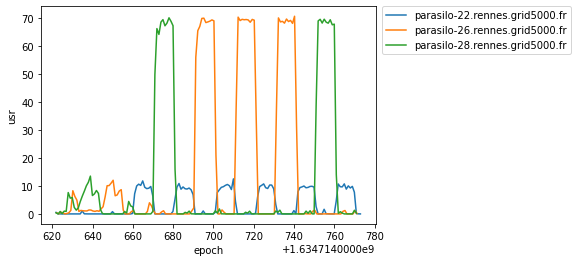

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=result, x="epoch", y="usr", hue="host")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

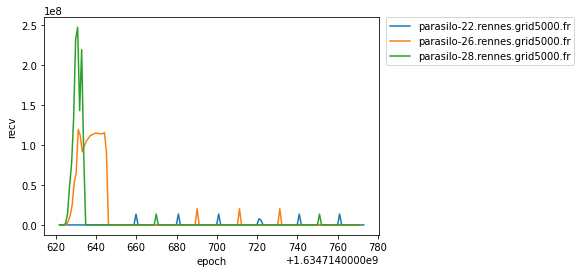

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=result, x="epoch", y="recv", hue="host")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

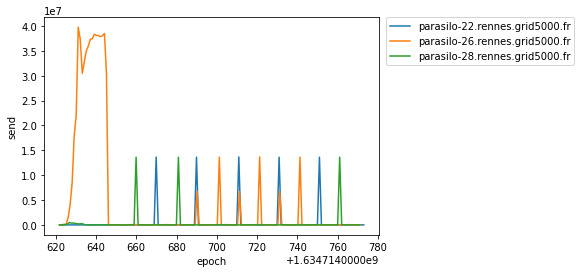

In [14]:
sns.lineplot(data=result, x="epoch", y="send", hue="host")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

## Clean up

In [15]:
provider.destroy()

INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading fl_on_bms from grenoble
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading fl_on_bms from lille
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading fl_on_bms from luxembourg
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading fl_on_bms from lyon
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading fl_on_bms from nancy
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading fl_on_bms from nantes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading fl_on_bms from rennes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading 1824374 from rennes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading fl_on_bms from sophia
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Killing the job (rennes, 1824374)
